In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os

In [12]:
acs_to_hpi = {
    12060:'Atlanta-Sandy Springs-Alpharetta, GA',
    12580:'Baltimore-Columbia-Towson, MD',
    14460:'Boston, MA (MSAD)',
    16980:'Chicago-Naperville-Evanston, IL (MSAD)',
    17140:'Cincinnati, OH-KY-IN',
    17460:'Cleveland-Elyria, OH',
    19100:'Dallas-Plano-Irving, TX (MSAD)',
    19740:'Denver-Aurora-Lakewood, CO',
    19820:'Detroit-Dearborn-Livonia, MI (MSAD)',
    26420:'Houston-The Woodlands-Sugar Land, TX',
    28140:'Kansas City, MO-KS',
    31080:'Los Angeles-Long Beach-Glendale, CA (MSAD)',
    33100:'Miami-Miami Beach-Kendall, FL (MSAD)',
    33340:'Milwaukee-Waukesha, WI',
    33460:'Minneapolis-St. Paul-Bloomington, MN-WI',
    35620:'New York-Jersey City-White Plains, NY-NJ (MSAD)',
    37980:'Philadelphia, PA (MSAD)',
    38060:'Phoenix-Mesa-Chandler, AZ',
    38300:'Pittsburgh, PA',
    38900:'Portland-Vancouver-Hillsboro, OR-WA',
    40140:'Riverside-San Bernardino-Ontario, CA',
    41740:'San Diego-Chula Vista-Carlsbad, CA',
    41860:'San Francisco-San Mateo-Redwood City, CA (MSAD)',
    41180:'St. Louis, MO-IL',
    45300:'Tampa-St. Petersburg-Clearwater, FL',
    47900:'Washington-Arlington-Alexandria, DC-VA-MD-WV (MSAD)',
}

acs_to_cpi = {
    12060:'Atlanta-Sandy Springs-Roswell, GA',
    12580:'Baltimore-Columbia-Towson, MD',
    14460:'Boston-Cambridge-Newton, MA-NH',
    16980:'Chicago-Naperville-Elgin, IL-IN-WI',
    17140:'Cincinnati-Hamilton, OH-KY-IN',
    17460:'Cleveland-Akron, OH',
    19100:'Dallas-Fort Worth-Arlington, TX',
    19740:'Denver-Aurora-Lakewood, CO',
    19820:'Detroit-Warren-Dearborn, MI',
    26420:'Houston-The Woodlands-Sugar Land, TX',
    28140:'Kansas City, MO-KS',
    31080:'Los Angeles-Long Beach-Anaheim, CA',
    33100:'Miami-Fort Lauderdale-West Palm Beach, FL',
    33340:'Milwaukee-Racine, WI',
    33460:'Minneapolis-St.Paul-Bloomington, MN-WI',
    35620:'New York-Newark-Jersey City, NY-NJ-PA',
    37980:'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
    38060:'Phoenix-Mesa-Scottsdale, AZ',
    38300:'Pittsburgh, PA',
    38900:'Portland-Salem, OR-WA',
    40140:'Riverside-San Bernardino-Ontario, CA',
    41740:'San Diego-Carlsbad, CA',
    41860:'San Francisco-Oakland-Hayward, CA',
    41180:'St. Louis, MO-IL',
    45300:'Tampa-St. Petersburg-Clearwater, FL',
    47900:'Washington-Arlington-Alexandria, DC-VA-MD-WV',
}

acs_to_zillow = {
    12060:394347,
    12580:394358,
    14460:394404,
    16980:394463,
    17140:394466,
    17460:394475,
    19100:394514,
    19740:394530,
    19820:394532,
    26420:394692,
    28140:394735,
    31080:753899,
    33100:394856,
    33340:394862,
    33460:394865,
    35620:394913,
    37980:394974,
    38060:394976,
    38300:394982,
    38900:394998,
    40140:395025,
    41740:395056,
    41860:395057,
    41180:395121,
    45300:395148,
    47900:395209,
}

In [22]:
def hpi_date(row):
    if row.frequency != "quarterly":
        raise Exception("frequency no quarterly")
    date_map_quarterly = {
        "1":1,
        "2":4,
        "3":7,
        "4":10,
    }
    month = date_map_quarterly["{}".format(row.period)]
    date = datetime.date(row.yr, month, 1)
    return date

def cpi_date(row):
    cpi_date_map = {
            "M01":1,
            "M02":2,
            "M03":3,
            "M04":4,
            "M05":5,
            "M06":6,
            "M07":7,
            "M08":8,
            "M09":9,
            "M10":10,
            "M11":11,
            "M12":12,
            "M13":12,
            "S01":6,
            "S02":12,
            "S03":12
    }
    month = cpi_date_map[row.period]
    date = datetime.date(row.year, month, 1)
    return date

def last_day_of_month(date):
    if date.month == 12:
        return date.replace(day=31)
    return date.replace(month=date.month+1, day=1) - datetime.timedelta(days=1)

def calc_hpi_cpi_price_to_rent(geo_id, name, name_cpi, name_hpi, name_zillow):
    temp_hpi = hpi_df.loc[(hpi_df["place_name"]==name_hpi) & 
           (hpi_df["hpi_flavor"]=="all-transactions")
          ].sort_values("date")
    
    area_code = cpi_df_areas.loc[cpi_df_areas["area_name"]==name_cpi].area_code.item()
    temp_cpi = cpi_df[(cpi_df["area_code"]==area_code) & 
       (cpi_df["item_code"]=="SEHA") &
#        (cpi_df["periodicity"]=="R") &
       (cpi_df["seasonal"]=="U") 
      ].sort_values("date")
    
    price_to_rent_df = pd.DataFrame(columns={"name", "date", "rent", "price", "price_to_rent"})
    dates = set(list(temp_hpi.date.unique())  + list(temp_cpi.date.unique()))
    
    cpi_max_date = temp_cpi.date.max()
    hpi_max_date = temp_hpi.date.max()
    
    cpi_max_index = temp_cpi.loc[temp_cpi["date"]==cpi_max_date].sort_values("period").iloc[0].value
    hpi_max_index = temp_hpi.loc[temp_hpi["date"]==hpi_max_date].index_nsa.item()
    
    acs_max_year = cbsa_df.loc[(cbsa_df["geo_id"]==geo_id)].year.max()
    if int(cpi_max_date.strftime("%Y"))>acs_max_year:
        year = acs_max_year
    else:
        year = int(cpi_max_date.strftime("%Y"))
    
    most_recent_rent = cbsa_df.loc[(cbsa_df["geo_id"]==geo_id) & (cbsa_df["year"]==year
                  )].median_contract_rent.item()
    most_recent_home_val = zillow_df.loc[(zillow_df["RegionID"]==name_zillow),
                  last_day_of_month(hpi_max_date).strftime("%Y-%m-%e")].item()
    
    for n, date in enumerate(sorted(dates)):
        # Get CPI values
        cpi_max_date = temp_cpi.loc[(temp_cpi["date"]<=date)]
        if not cpi_max_date.empty:
            cpi_max_date = cpi_max_date.sort_values("date", ascending=False).iloc[0].date
        else: # If no values, continue 
            continue
        temp_cpi_df = temp_cpi.loc[(temp_cpi["date"]==cpi_max_date)].sort_values("period")
        cpi_val = temp_cpi_df.iloc[0].value

        # Get HPI values
        hpi_max_date = temp_hpi.loc[(temp_hpi["date"]<=date)]
        if not hpi_max_date.empty:
            hpi_max_date = hpi_max_date.sort_values("date", ascending=False).iloc[0].date
        else: # If no values, continue 
            continue
        hpi_val = temp_hpi.loc[temp_hpi["date"]==hpi_max_date].index_nsa.item()

        rent_val = cpi_val/cpi_max_index*most_recent_rent
        home_val = hpi_val/hpi_max_index*most_recent_home_val

        price_to_rent = home_val/(rent_val*12)
        price_to_rent_df.loc[n] = {"date":date, 
                                   "name":name,
                                   "rent":rent_val, 
                                   "price":home_val, 
                                   "price_to_rent":price_to_rent
                                  } 
    return price_to_rent_df
    

In [30]:
if not os.path.isfile("data/hpi_and_cpi_computed_historical.csv"): 
    hpi_df = pd.read_csv("data/HPI.csv")
    hpi_df = hpi_df.loc[(hpi_df["level"]=="MSA")]
    hpi_df["date"] = hpi_df.loc[(hpi_df["level"]=="MSA")].apply(lambda x: hpi_date(x), axis=1)

    cpi_df = pd.DataFrame()
    for file in os.listdir("data/cpi/areas"):
        if file.endswith(".txt"):
            cpi_df = cpi_df.append(pd.read_csv("data/cpi/areas/{}".format(file), sep="\t"))
    cpi_df = cpi_df.rename(columns=lambda x: x.strip())
    cpi_df["survey"] = cpi_df["series_id"].str[:2]
    cpi_df["seasonal"] = cpi_df["series_id"].str[2:3]
    cpi_df["periodicity"] = cpi_df["series_id"].str[3:4]
    cpi_df["area_code"] = cpi_df["series_id"].str[4:8]
    cpi_df["item_code"] = cpi_df["series_id"].str[8:].apply(lambda x: x.strip())
    cpi_df["date"] = cpi_df.apply(lambda x: cpi_date(x), axis=1)

    cpi_df_areas = pd.read_csv("data/cpi/cu.area.txt", sep="\t")
    cpi_df_series = pd.read_csv("data/cpi/cu.series.txt", sep="\t")
    cbsa_df = pd.read_csv("data/cbsa.csv")
    zillow_df = pd.read_csv("data/zillow_msa.csv")

    price_to_rent_df_main = pd.DataFrame(columns={"name", "date", "rent", "price", "price_to_rent"})
    for geo_id in cbsa_df.loc[cbsa_df['geo_id'].isin(list(acs_to_hpi.keys()))].geo_id.unique():
        name = cbsa_df.loc[cbsa_df['geo_id']==geo_id].head(1).name.item()                      
        print(name, geo_id)
        price_to_rent_df_main = price_to_rent_df_main.append(calc_hpi_cpi_price_to_rent(
            geo_id, 
            name, 
            acs_to_cpi[geo_id], 
            acs_to_hpi[geo_id],
            acs_to_zillow[geo_id]
        ))

    price_to_rent_df_main.to_csv("data/hpi_and_cpi_computed_historical.csv")
    
else:
    price_to_rent_df_main = pd.read_csv("data/hpi_and_cpi_computed_historical.csv")

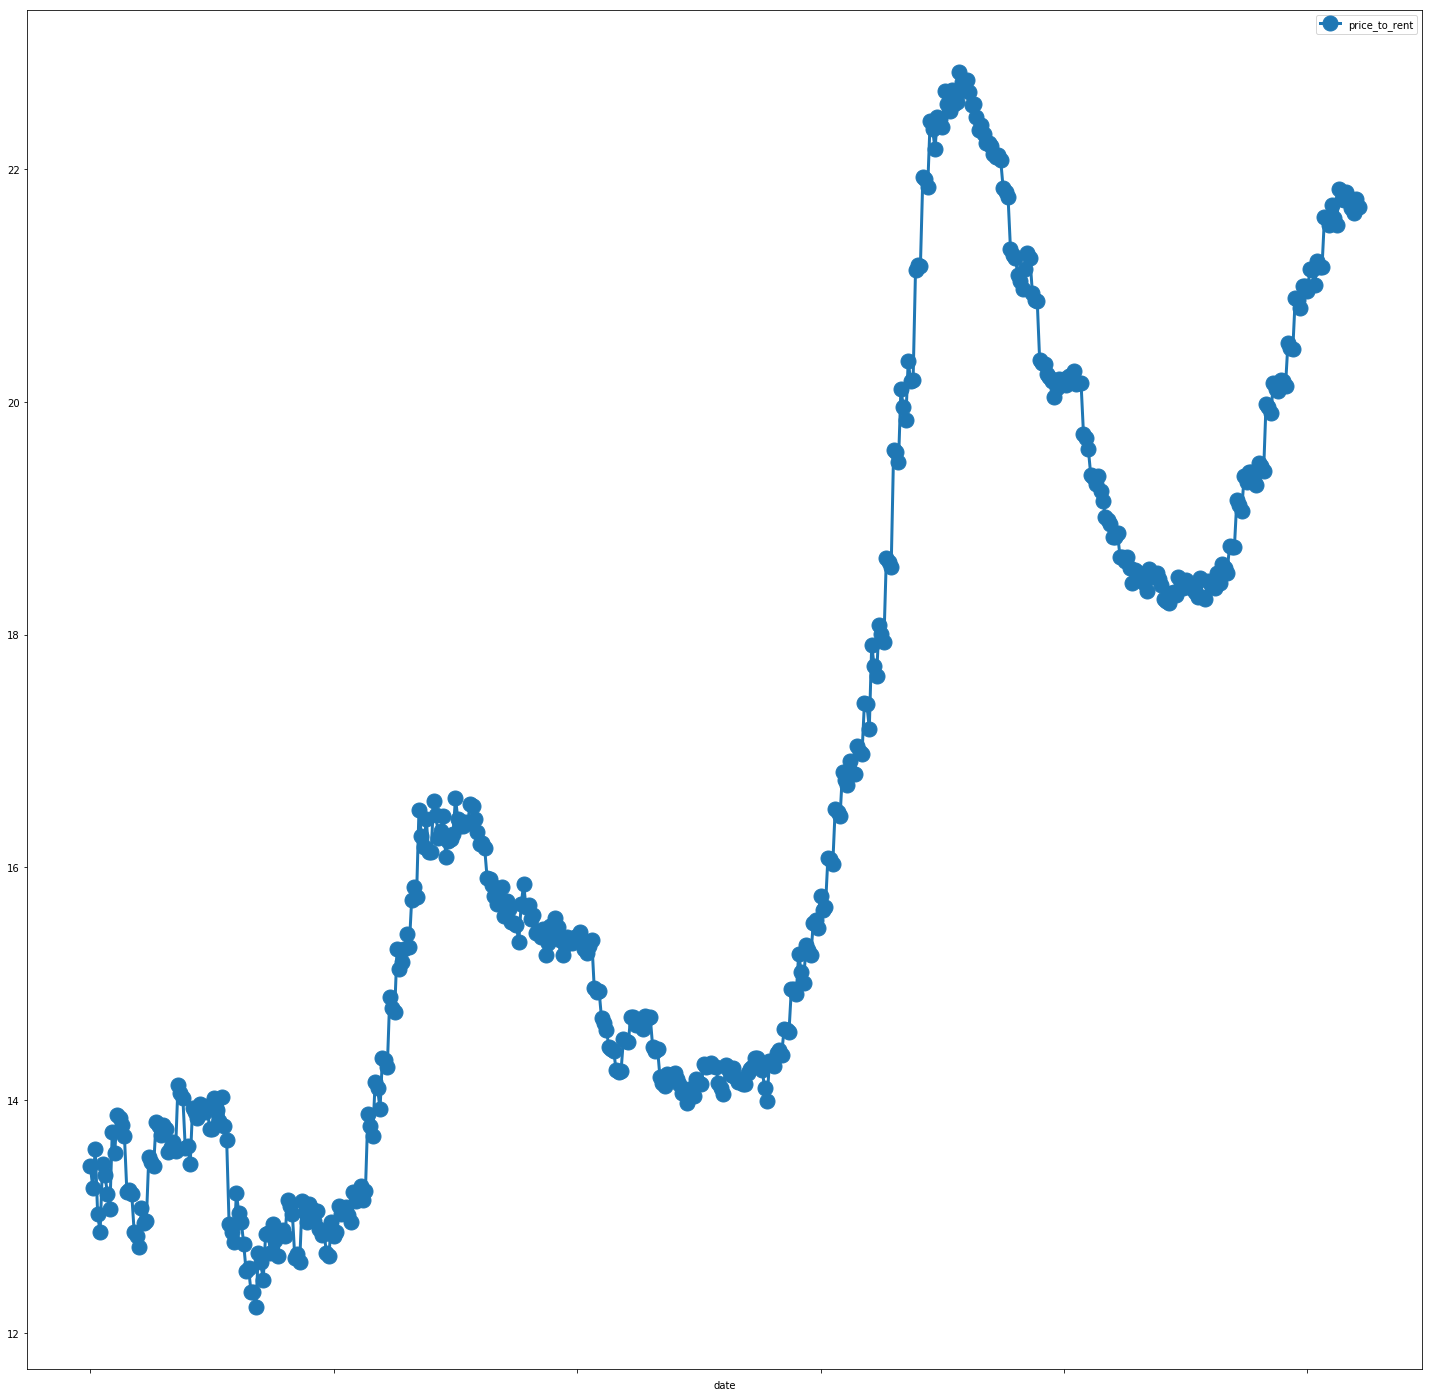

In [31]:
city = "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area"
column = "price_to_rent"
plot_df = price_to_rent_df_main.loc[price_to_rent_df_main["name"]==city]

ax = plot_df.plot(
    y = "price_to_rent",
    x = "date",
    figsize=(25,25),
    legend=True,
    linewidth=3,
    marker='o',
    markersize=15,
)

# plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
# matplotlib.rcParams.update({'font.size': 25})

# ax.set_title('Great Recession Percent Change in Employment vs Percent Change in Home Values', fontdict={
#     'fontsize': 30, 'fontweight': 'medium'})

# plt.xlabel('Percent Change Employment', fontsize=25)
# plt.xticks(np.arange(2010, 2020, step=1))
# plt.ylabel('Percent Change Home Values', fontsize=25)
# plt.savefig('price_to_rent_{}.jpg'.format(city),  dpi=300, bbox_inches = "tight")
plt.show()
